In [2]:
# === 1. Package Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import community as community_louvain


In [3]:
# === 2. Load Datasets ===
nutrients_df = pd.read_csv("./Processed/Cleaned_Nutrients_Data.csv", parse_dates=["Date"], dayfirst=True)
phyto_df = pd.read_csv("./Processed/Cleaned_Phytoplankton_Data.csv", parse_dates=["Date"], dayfirst=True)
env_df = pd.read_csv("./Processed/Cleaned_WindermereSouth_WaterMonitoring_Data.csv", parse_dates=["Date"], dayfirst=True)



In [4]:
# === 3. Process Nutrients + Hydrology for Windermere South ===
nutrients_df = nutrients_df.set_index("Date")
windmere_df = nutrients_df[nutrients_df["Name"].str.contains("Windermere South", case=False)].copy()

nutrient_vars = ['Nitrate', 'Ammonium', 'Phosphate']
hydro_vars = ['Surface Oxygen', 'Surface Temperature', 'Secchi Depth']

selected_nutrient_df = windmere_df[nutrient_vars + hydro_vars]
monthly_nutrient_hydro = selected_nutrient_df.groupby(pd.Grouper(freq='ME')).mean()


In [8]:
# === 4. Process Phytoplankton Data for Windermere South ===

# Drop incomplete rows
phyto_df = phyto_df.dropna(subset=["Date", "Category", "Value"])

# Group by Date, Lake Name, and Category → then pivot Category as columns
phyto_grouped = phyto_df.groupby(["Date", "Name", "Category"])["Value"].sum().unstack(fill_value=0)

# Filter for Windermere South
phyto_windmere = phyto_grouped.xs("Windermere South", level=1)

# Ensure Date is a datetime object
phyto_windmere = phyto_windmere.reset_index()
phyto_windmere["Date"] = pd.to_datetime(phyto_windmere["Date"], errors="coerce")

# Set index and group by month-end
phyto_windmere = phyto_windmere.set_index("Date")
fixed_phyto_cols = ['Cyano-bacteria', 'Diatoms', 'Green Algae', 'Red Algae', 'Dinoflagellates']
monthly_phyto = phyto_windmere[fixed_phyto_cols].groupby(pd.Grouper(freq='ME')).sum()




In [10]:
# === 5. Process Meteorological Data from Windermere South ===

# Ensure 'Date' is in datetime format
env_df["Date"] = pd.to_datetime(env_df["Date"], errors="coerce")

# Set index and select meteorological variables
monthly_env = env_df.set_index("Date")[["Air Temperature", "Pyranometer", "Wind Speed"]]

# Aggregate by month-end
monthly_env = monthly_env.groupby(pd.Grouper(freq='ME')).mean()

# Preview to confirm
print("✅ Monthly meteorological shape:", monthly_env.shape)
print("✅ Columns:", monthly_env.columns.tolist())


✅ Monthly meteorological shape: (91, 3)
✅ Columns: ['Air Temperature', 'Pyranometer', 'Wind Speed']


In [12]:
# === 6. Merge Nutrient + Hydrology + Phytoplankton (No Meteorology) ===

# Restrict to overlapping years between nutrients and phytoplankton
start, end = "1978-01-01", "2003-12-31"
monthly_nutrient_hydro = monthly_nutrient_hydro.loc[start:end]
monthly_phyto = monthly_phyto.loc[start:end]

# Merge only these two
monthly_all = monthly_nutrient_hydro.join(monthly_phyto, how="inner")

# Drop missing months (if any)
monthly_all.dropna(inplace=True)

# Confirm merged structure
print("✅ Merged forcing shape:", monthly_all.shape)
print("✅ Columns:", monthly_all.columns.tolist())
print("✅ Date range:", monthly_all.index.min().date(), "→", monthly_all.index.max().date())


✅ Merged forcing shape: (312, 11)
✅ Columns: ['Nitrate', 'Ammonium', 'Phosphate', 'Surface Oxygen', 'Surface Temperature', 'Secchi Depth', 'Cyano-bacteria', 'Diatoms', 'Green Algae', 'Red Algae', 'Dinoflagellates']
✅ Date range: 1978-01-31 → 2003-12-31


/var/folders/jh/4dsp7k0j5257kvfjxfbt8jl00000gn/T/ipykernel_9624/2917063423.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


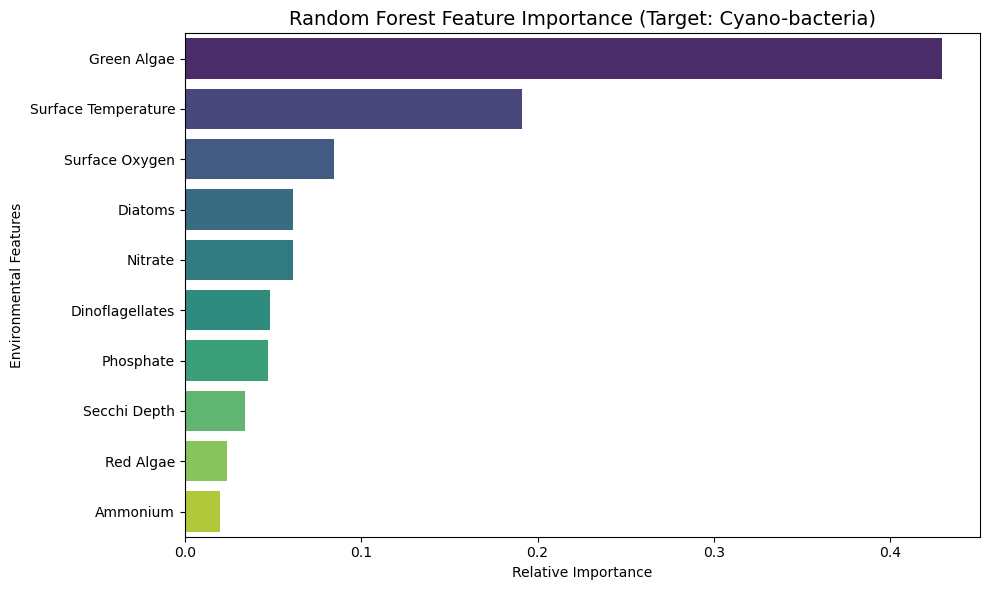

In [14]:
# === Step 1: Define Target and Features ===
# We aim to predict cyanobacteria abundance based on environmental variables
target_col = "Cyano-bacteria"
X = monthly_all.drop(columns=[target_col])  # Predictor variables
y = monthly_all[target_col]                # Target variable

# === Step 2: Standardize Features ===
# Random Forest does not require scaling, but we standardize to align with clustering & cosine similarity later
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# === Step 3: Fit Random Forest Model ===
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_scaled_df, y)

# === Step 4: Extract and Sort Feature Importances ===
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# === Step 5: Visualize Feature Importances ===
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Random Forest Feature Importance (Target: Cyano-bacteria)", fontsize=14)
plt.xlabel("Relative Importance")
plt.ylabel("Environmental Features")
plt.tight_layout()
plt.show()



In [16]:
# === 8. Drop Bottom 3 Least Important Features ===
least_important = importances.tail(3).index.tolist()
print("🔻 Dropping least important features:", least_important)

X_reduced = X_scaled_df.drop(columns=least_important)
monthly_all = monthly_all.drop(columns=least_important)


🔻 Dropping least important features: ['Secchi Depth', 'Red Algae', 'Ammonium']


✅ Best number of clusters based on silhouette score: k = 5


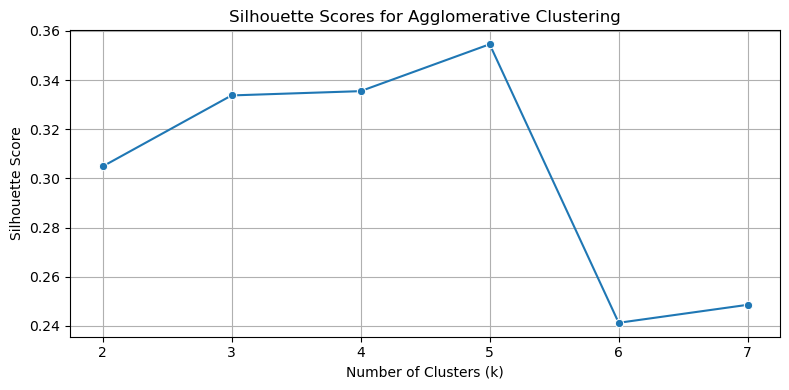

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# === Step 1: Try cluster sizes (k = 2 to 7) and compute silhouette scores
sil_scores = {}
for k in range(2, 8):  # Testing cluster sizes from 2 to 7
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_reduced)
    
    # Only calculate score if clustering isn't trivial (i.e., not 1 cluster)
    if len(set(labels)) > 1:
        sil_scores[k] = silhouette_score(X_reduced, labels)

# === Step 2: Choose best k
best_k = max(sil_scores, key=sil_scores.get)
print(f"✅ Best number of clusters based on silhouette score: k = {best_k}")

# === Step 3: Fit final model and assign cluster labels
final_model = AgglomerativeClustering(n_clusters=best_k)
monthly_all["Cluster"] = final_model.fit_predict(X_reduced)

# === Step 4: Visualize silhouette scores
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(sil_scores.keys()), y=list(sil_scores.values()), marker="o")
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# === 10. Assign Descriptive Seasonal Labels ===
cluster_labels_map = {
    0: "Spring Transition",
    1: "Early Summer Bloom",
    2: "Mid-Summer Peak",
    3: "Late Summer Bloom",
    4: "Fall Decline"
}

# === Step 2: Apply label mapping to the DataFrame
monthly_all["Cluster_Label"] = monthly_all["Cluster"].map(cluster_labels_map)

# === Step 3: Preview the assignment
print(monthly_all["Cluster_Label"].value_counts())

Cluster_Label
Spring Transition     163
Mid-Summer Peak       111
Early Summer Bloom     26
Fall Decline           10
Late Summer Bloom       2
Name: count, dtype: int64


In [22]:
# === 11. Cosine Similarity Graph + Louvain Detection ===
# === Step 1: Build Cosine Similarity Matrix ===

# Step 1: Recalculate cosine similarity
cos_sim = cosine_similarity(X_reduced)

# Step 2: Apply lower threshold (retain more seasonal links)
cos_sim[cos_sim < 0.80] = 0

# Step 3: Rebuild graph
G = nx.from_numpy_array(cos_sim)

# Add temporal labels to graph nodes
monthly_all["Label"] = monthly_all.index.strftime("%Y-%m")
label_dict = dict(enumerate(monthly_all["Label"]))
G = nx.relabel_nodes(G, label_dict)

# Step 4: Run Louvain community detection
partition = community_louvain.best_partition(G)
monthly_all["Louvain"] = monthly_all["Label"].map(partition)

# Step 5: Check graph structure
print("✅ Graph: ", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")
print("✅ Louvain communities detected:", len(set(partition.values())))


✅ Graph:  312 nodes, 4401 edges
✅ Louvain communities detected: 15


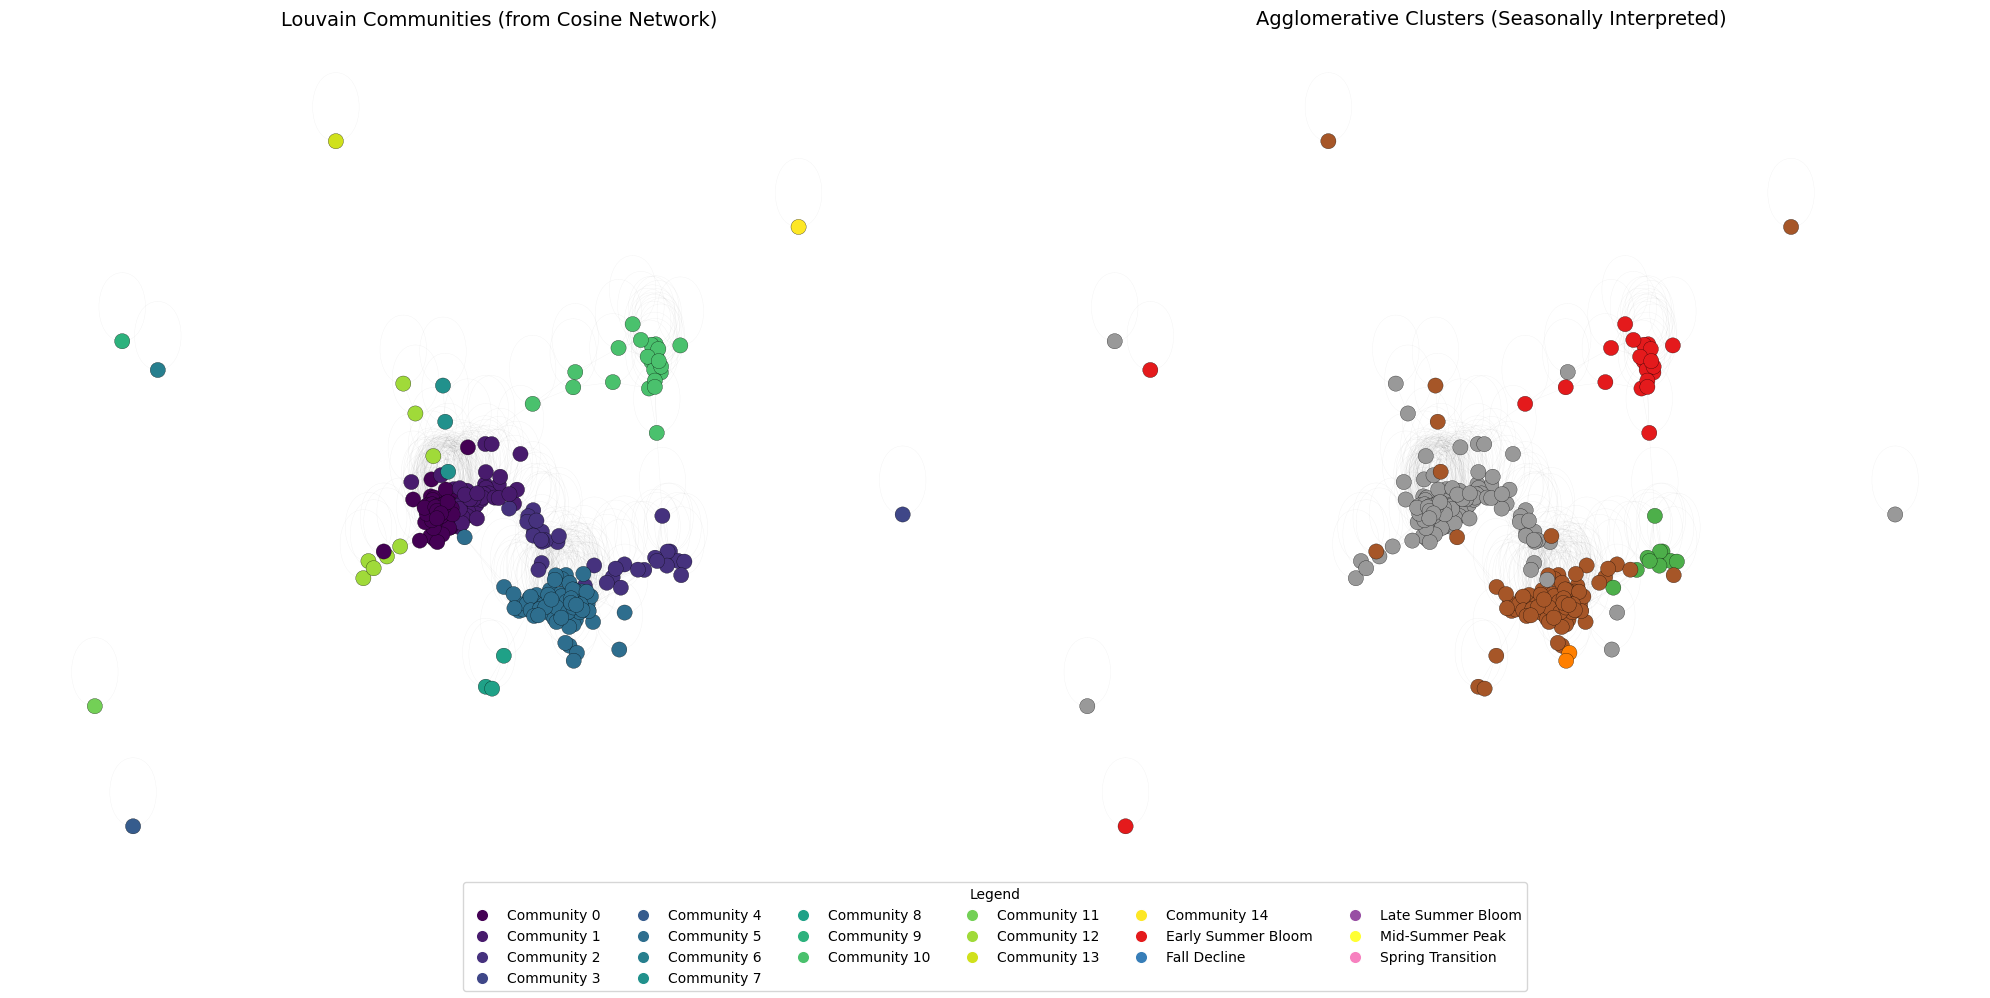

In [24]:
# === Final Louvain vs Cluster Panel Plot (Clean & Indexed) ===

# Step 1: Ensure label alignment
monthly_all["Label"] = monthly_all.index.strftime("%Y-%m")
monthly_all = monthly_all.set_index("Label")
node_labels = list(G.nodes())

# Step 2: Generate layout
pos = nx.spring_layout(G, seed=42)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# === Panel 1: Louvain ===
louvain_colors = monthly_all.loc[node_labels]["Louvain"].astype("category").cat.codes
nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[0])
nx.draw_networkx_nodes(G, pos, node_color=louvain_colors, cmap=plt.cm.viridis,
                       node_size=120, edgecolors='black', linewidths=0.2, ax=axes[0])
axes[0].set_title("Louvain Communities (from Cosine Network)", fontsize=14)
axes[0].axis("off")

# === Panel 2: Agglomerative Clusters ===
cluster_colors = monthly_all.loc[node_labels]["Cluster_Label"].astype("category").cat.codes
nx.draw_networkx_edges(G, pos, alpha=0.05, edge_color="black", width=0.3, ax=axes[1])
nx.draw_networkx_nodes(G, pos, node_color=cluster_colors, cmap=plt.cm.Set1,
                       node_size=120, edgecolors='black', linewidths=0.2, ax=axes[1])
axes[1].set_title("Agglomerative Clusters (Seasonally Interpreted)", fontsize=14)
axes[1].axis("off")

# === Legends ===
louvain_ids = sorted(monthly_all['Louvain'].dropna().unique())
cluster_labels = sorted(monthly_all['Cluster_Label'].dropna().unique())

louvain_legend = [
    Line2D([0], [0], marker='o', color='w', label=f"Community {i}",
           markerfacecolor=plt.cm.viridis(i / max(louvain_ids)), markersize=9)
    for i in louvain_ids
]

cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=plt.cm.Set1(i / len(cluster_labels)), markersize=9)
    for i, label in enumerate(cluster_labels)
]

fig.legend(handles=louvain_legend + cluster_legend,
           loc='lower center', ncol=6, frameon=True, fontsize=10, title='Legend')

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()



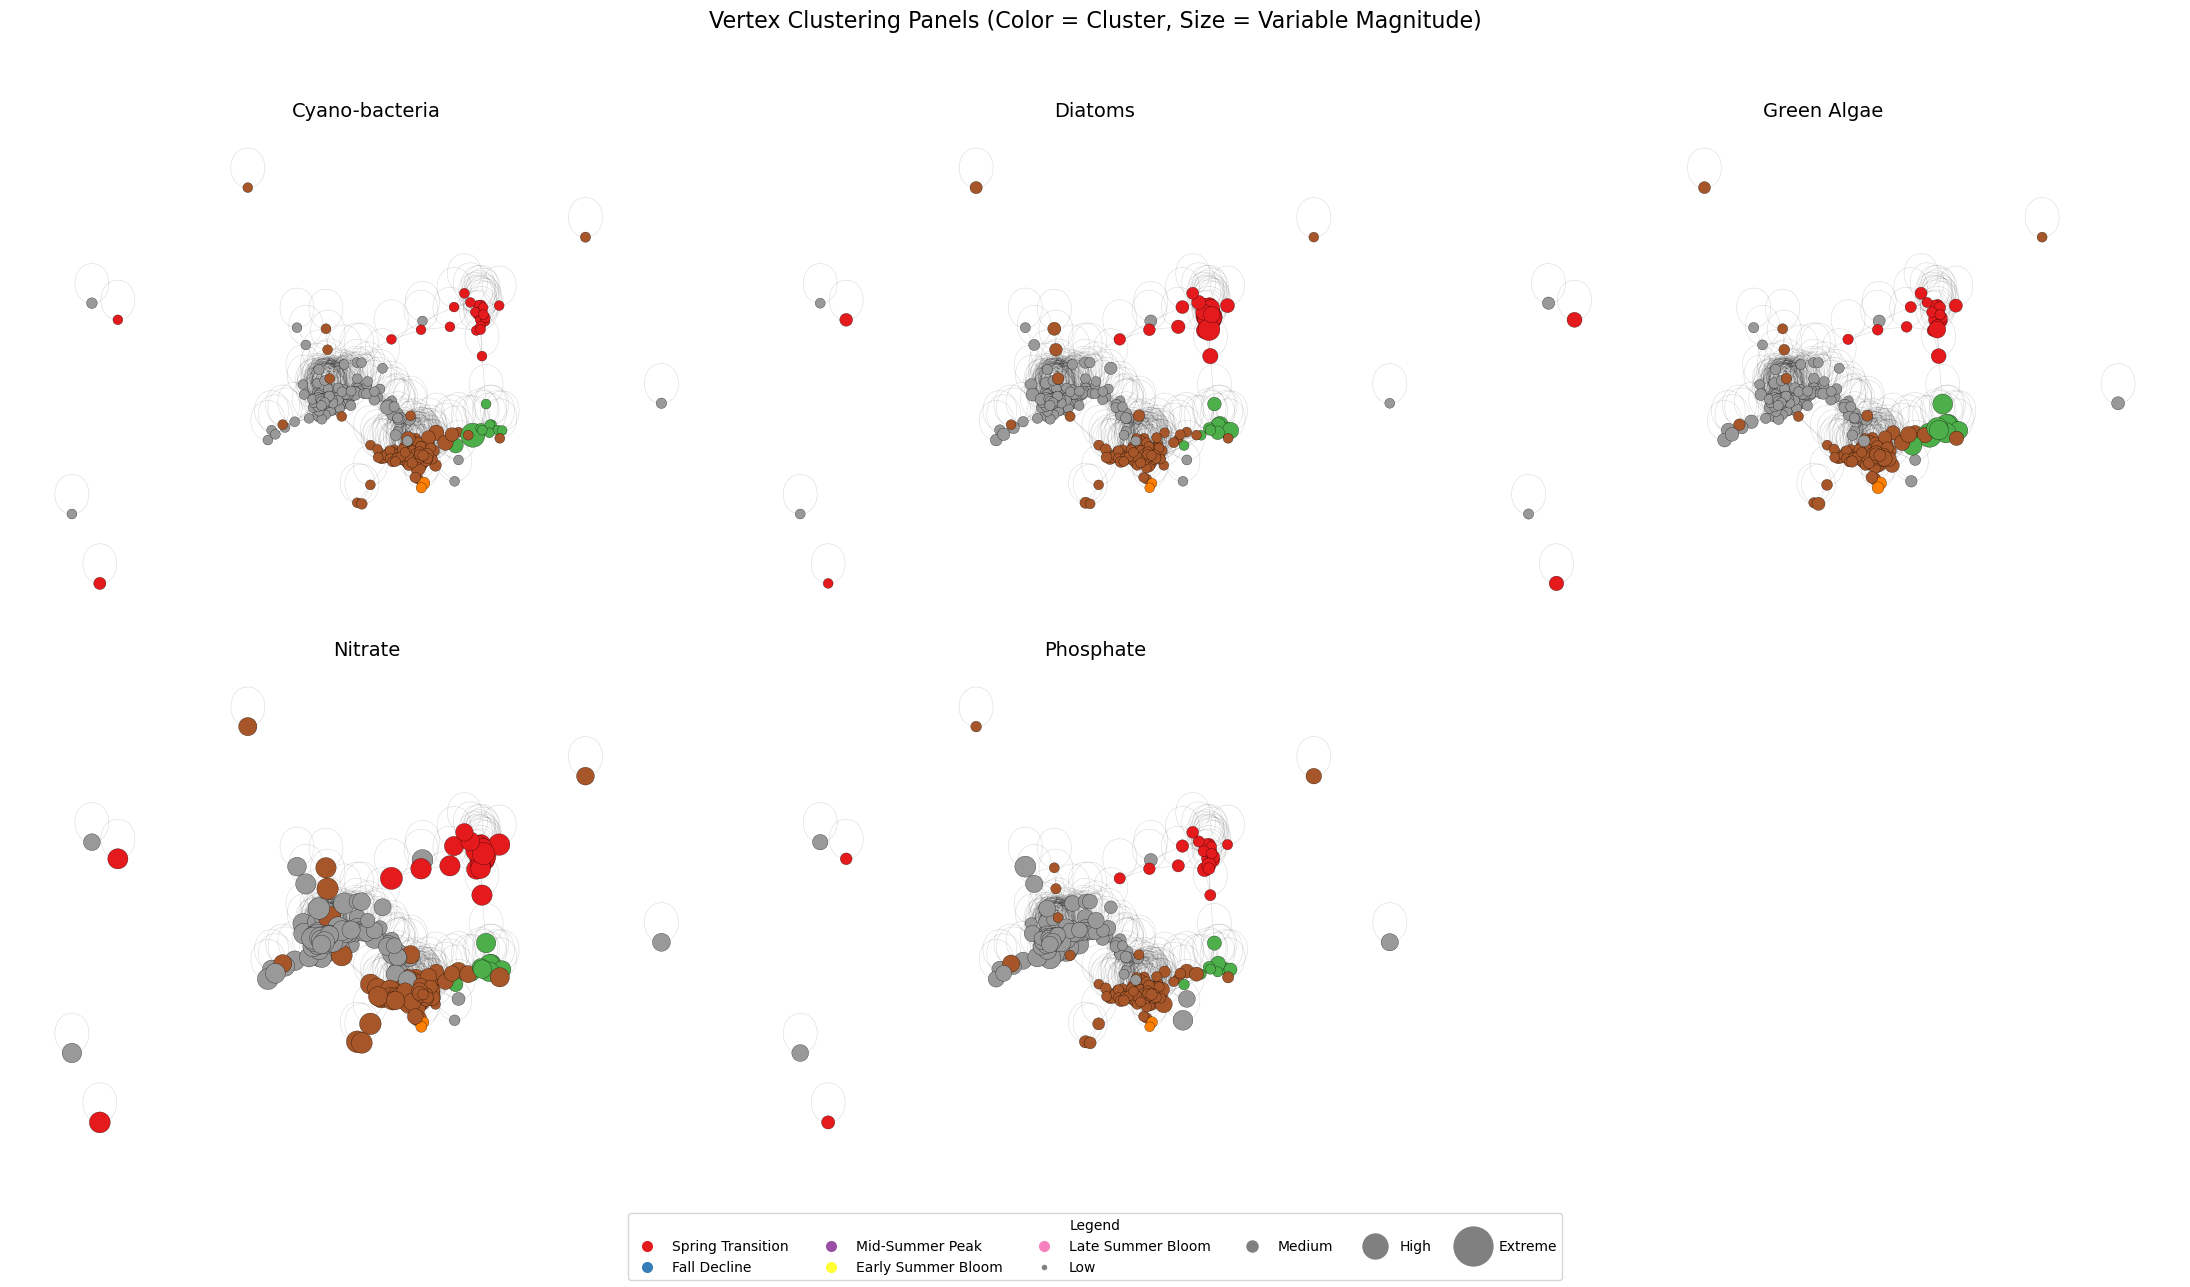

In [25]:
# === 13.Vertex Panel Plot (Size = Variable, Color = Cluster_Label) ===

# Variables to visualize
variables = ['Cyano-bacteria', 'Diatoms', 'Green Algae', 'Nitrate', 'Phosphate']
n_panels = len(variables)

# Layout
fig, axes = plt.subplots(2, 3, figsize=(22, 13))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]

    # === Size: variable magnitude (scaled)
    values = monthly_all.loc[node_labels, var].fillna(0)
    scaled_sizes = (values - values.min()) / (values.max() - values.min())
    scaled_sizes = scaled_sizes * 250 + 50  # normalize to 50–300 size range

    # === Color: cluster label as category
    cluster_codes = monthly_all.loc[node_labels, "Cluster_Label"].astype("category").cat.codes

    # Draw edges + nodes
    nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color="black", width=0.4, ax=ax)
    nx.draw_networkx_nodes(G, pos,
                           node_color=cluster_codes,
                           node_size=scaled_sizes,
                           cmap=plt.cm.Set1,
                           edgecolors='black',
                           linewidths=0.2,
                           ax=ax)
    
    ax.set_title(var, fontsize=14)
    ax.axis("off")

# === Remove unused subplot if n_panels < 6
if len(variables) < len(axes):
    fig.delaxes(axes[-1])

# === Add legends
cluster_labels = monthly_all["Cluster_Label"].dropna().unique()
cluster_legend = [
    Line2D([0], [0], marker='o', color='w', label=lbl,
           markerfacecolor=plt.cm.Set1(i / len(cluster_labels)), markersize=9)
    for i, lbl in enumerate(cluster_labels)
]

size_legend = [
    Line2D([0], [0], marker='o', color='w', label='Low',
           markerfacecolor='gray', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Medium',
           markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='High',
           markerfacecolor='gray', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='Extreme',
           markerfacecolor='gray', markersize=30)
]

fig.legend(handles=cluster_legend + size_legend,
           loc='lower center', ncol=6, frameon=True, fontsize=10, title='Legend')

plt.suptitle("Vertex Clustering Panels (Color = Cluster, Size = Variable Magnitude)", fontsize=16)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


In [30]:
# === 14. Cluster Summary Table ===
summary = monthly_all.groupby("Cluster_Label")[[
    "Cyano-bacteria", "Diatoms", "Green Algae", "Nitrate", "Phosphate", "Surface Temperature"
]].mean().round(2)
summary["Months"] = monthly_all["Cluster_Label"].value_counts().reindex(summary.index)
summary = summary.reset_index()
summary


,Cluster_Label,Cyano-bacteria,Diatoms,Green Algae,Nitrate,Phosphate,Surface Temperature,Months
0,Early Summer Bloom,2.45,10414.49,2205.79,526.95,4.10,8.58,26
1,Fall Decline,52.92,5096.23,12908.77,375.79,4.00,12.24,10
2,Late Summer Bloom,29.24,1.30,2115.64,44.25,1.46,17.35,2
3,Mid-Summer Peak,19.51,285.10,1659.28,302.90,2.23,15.90,111
4,Spring Transition,4.40,394.15,540.20,500.30,14.89,7.53,163
